<a href="https://colab.research.google.com/github/vamado09/Applied-Data-Science/blob/main/Pricing_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# SKU PERFORMANCE

SQL Code I need:

In [ ]:
#SELECT SKU_NUMBER,
#BILLING_DATE,
#SUM(NET_SALES) AS TOTAL_NET_SALES,
#SUM(UNITS_SOLD)AS TOTAL_UNITS_SOLD,
#SUM(NET_SALES)/SUM(UNITS_SOLD) AS AVERAGE_PRICE,
#SUM(GROSS_MARGIN) AS TOTAL_GROSS_MARGIN

#FROM WFF_US_EDW_DEV.VISUAL.FCT_SALES_ITEMS
#WHERE BILLING_DATE BETWEEN 20240601 AND 20240930
#AND MOVEMENT_TYPE = 'Sales'
#AND SKU_NUMBER = 2654
#GROUP BY SKU_NUMBER, BILLING_DATE
#ORDER BY BILLING_DATE;

INCORPORATE THE ONE IN ONE DRIVE

In [2]:
df = pd.read_csv('/content/PLU_2654.csv')
df['BILLING_DATE'] = pd.to_datetime(df['BILLING_DATE'], format='%Y%m%d')
df.head()

,SKU_NUMBER,BILLING_DATE,TOTAL_NET_SALES,TOTAL_UNITS_SOLD,AVERAGE_PRICE,TOTAL_COGS,TOTAL_GROSS_MARGIN
0,2654,2024-06-01,796.47,160.0,4.977938,556.21,240.26
1,2654,2024-06-02,1258.29,253.0,4.973478,880.10,378.19
2,2654,2024-06-03,1068.66,215.0,4.970512,748.60,320.06
3,2654,2024-06-04,624.78,126.0,4.958571,438.93,185.85
4,2654,2024-06-05,517.16,104.0,4.972692,361.95,155.21


In [9]:
#df.dtypes

# Price Elasticity

- ELASTIC: Traditionally, a product is considered to have elastic demand if the absolute value of its price elasticity is greater than 1. This means demand is highly responsive to price changes.

- INELASTIC: If the absolute value is less than 1, demand is relatively unresponsive to price changes.

- Unit Elastic: An elasticity of exactly -1 means that the percentage change in quantity demanded is equal to the percentage change in price.

**Signs:**
- Positive Elasticity indicates that as the price increases, demand also increases, which is unusual and typically not expected.

- Negative Elasticity is more common and indicates that as the price increases, demand decreases.

Price elasticity is a measure that tells us how the demand for a product changes when its price changes. For example, if we increase the price of a ground beef, will people buy fewer of them? If they buy a lot fewer, we say the ground beef has high price elasticity.

-  If a product has high elasticity, even a small price increase might lead to a significant drop in sales. On the other hand, if a product has low elasticity, it means that sales are not very sensitive to price changes, which might allow more flexibility in raising prices without losing customers.

So, for my code below I need:

- Percentage Changes: We look at how much the price of a product has changed from one day to the next and how much the quantity sold has changed.

- Avoiding Errors: Sometimes, when calculating changes, the price might not change from one day to the next, which can lead to errors (like trying to divide by zero). To avoid this, I tweak calculations a bit by adding a very tiny number to the denominator (the number we're dividing by). This way, we never end up dividing by zero.


- Cleaning Up Extreme Values: Sometimes, the calculation gives us unrealistic numbers (like saying demand is infinitely sensitive to price changes). We can adjust these by replacing them with more typical values, so they don’t throw off our overall understanding.

- Filling in Gaps: If there are any days where the calculation can’t be done (maybe because there’s missing data), we fill in those gaps with average values from other days. This way, we have a complete picture of how price changes affect sales over time.


In [3]:
def elasticity_demand(elasticity):
    if elasticity < -1:
        return "Elastic Demand"
    elif -1 <= elasticity <= 0:
        return "Inelastic Demand"
    else:
        return "Other"

In [41]:
# Inspect days with zero price change
#zero_price_change = df[df['price_change'] == 0]
#print("Days with Zero Price Change:\n", zero_price_change)

# Inspect days with zero demand change
#zero_demand_change = df[df['demand_change'] == 0]
#print("Days with Zero Demand Change:\n", zero_demand_change)

# Find extreme outliers in sales or prices
#high_prices = df[df['AVERAGE_PRICE'] > df['AVERAGE_PRICE'].quantile(0.99)]
#low_prices = df[df['AVERAGE_PRICE'] < df['AVERAGE_PRICE'].quantile(0.01)]
#high_sales = df[df['TOTAL_UNITS_SOLD'] > df['TOTAL_UNITS_SOLD'].quantile(0.99)]
#low_sales = df[df['TOTAL_UNITS_SOLD'] < df['TOTAL_UNITS_SOLD'].quantile(0.01)]

#print("High Prices:\n", high_prices)
#print("Low Prices:\n", low_prices)
#print("High Sales:\n", high_sales)
#print("Low Sales:\n", low_sales)


In [4]:
# Calculate percentage changes in price and units sold
df['price_change'] = df['AVERAGE_PRICE'].pct_change().fillna(0)
df['demand_change'] = df['TOTAL_UNITS_SOLD'].pct_change().fillna(0)

# Calculate price elasticity of demand, handling zero price change cases
df['price_elasticity'] = np.where(df['price_change'] == 0, 0, df['demand_change'] / df['price_change'])

# Handle any remaining infinite values possibly from very small price changes
df['price_elasticity'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['price_elasticity'].fillna(df['price_elasticity'].median(), inplace=True)

# Optionally cap extreme values using quantile-based capping
cap_upper = df['price_elasticity'].quantile(0.95)
cap_lower = df['price_elasticity'].quantile(0.05)
df['price_elasticity'] = np.clip(df['price_elasticity'], cap_lower, cap_upper)

df['demand_type'] = df['price_elasticity'].apply(elasticity_demand)
df[['BILLING_DATE', 'AVERAGE_PRICE', 'TOTAL_UNITS_SOLD', 'price_elasticity', 'demand_type']]

,BILLING_DATE,AVERAGE_PRICE,TOTAL_UNITS_SOLD,price_elasticity,demand_type
0,2024-06-01,4.977938,160.0,0.000000,Inelastic Demand
1,2024-06-02,4.973478,253.0,-648.860958,Elastic Demand
2,2024-06-03,4.970512,215.0,251.802178,Other
3,2024-06-04,4.958571,126.0,172.322134,Other
4,2024-06-05,4.972692,104.0,-61.312210,Elastic Demand
...,...,...,...,...,...
97,2024-09-06,5.000000,148.0,0.000000,Inelastic Demand
98,2024-09-07,5.000000,178.0,0.000000,Inelastic Demand
99,2024-09-08,5.000000,171.0,0.000000,Inelastic Demand
100,2024-09-09,4.998476,164.0,134.269006,Other


# PLU Analysis

In [5]:
past_3months_df = df[df['BILLING_DATE'] < '2024-09-01']
current_month_df = df[df['BILLING_DATE'] >= '2024-09-01']

## Calculating Monthly Elasticity

Why Monthly Analysis is Effective?

- Manageability: Monthly data aggregation reduces noise from daily fluctuations and helps in identifying more stable trends. It simplifies the analysis by focusing on broader patterns, making it easier to observe the impact of price changes on demand over a significant period.

- Actionable Insights: Monthly insights are more actionable for strategic decisions. Daily data can be too granular, potentially leading to reactive rather than strategic decisions.

- Seasonality and Trends: Analyzing data on a monthly basis allows for the identification of seasonal effects and longer-term trends that might be missed with daily analysis.

In [6]:
#def calculate_monthly_elasticity(data):
    # Group data by month and calculate average elasticity
    #monthly_data = data.groupby(data['BILLING_DATE'].dt.to_period("M")).agg({'price_elasticity': 'mean'}).reset_index()
    #monthly_data['Month'] = monthly_data['BILLING_DATE'].dt.to_timestamp()  # Convert Period to Timestamp

    # Determine demand type based on elasticity
    #monthly_data['demand_type'] = monthly_data['price_elasticity'].apply(lambda x: 'Elastic Demand' if abs(x) > 1 else 'Inelastic Demand')

    # Recommend pricing action based on elasticity
    #monthly_data['pricing_recommendation'] = monthly_data['price_elasticity'].apply(
        #lambda x: 'Increase Price' if x < -1 else ('Decrease Price' if x > 1 else 'Maintain Price')
    #)
    #return monthly_data[['Month', 'price_elasticity', 'demand_type', 'pricing_recommendation']]

Function to calculate monthly elasticity that better aligns with strategic goals of focusing on sales and customer responsiveness:

In [36]:
def calculate_monthly_elasticity(data):
    # Group data by month and calculate average elasticity
    monthly_data = data.groupby(data['BILLING_DATE'].dt.to_period("M")).agg({'price_elasticity': 'mean'}).reset_index()
    monthly_data['Month'] = monthly_data['BILLING_DATE'].dt.to_timestamp()  # Correct conversion of period to timestamp

    # Determine demand type based on elasticity
    monthly_data['demand_type'] = monthly_data['price_elasticity'].apply(
        lambda x: 'Elastic Demand' if abs(x) > 1 else 'Inelastic Demand'
    )

    # Recommend pricing action based on elasticity
    monthly_data['pricing_recommendation'] = monthly_data['price_elasticity'].apply(
        lambda x: 'Decrease Price' if x < -1 else ('Increase Price' if x > 1 else 'Maintain Price')
    )
    return monthly_data[['Month', 'price_elasticity', 'demand_type', 'pricing_recommendation']]


Logic adjusted:

- Decrease Price: When elasticity is less than -1, suggesting a price decrease could lead to an increase in sales volume that might more than offset the lower price per unit.

- Increase Price: When elasticity is greater than 1, suggesting a price increase as the demand is relatively insensitive, potentially maximizing revenue without significantly reducing sales volume.

- Maintain Price: When the elasticity does not significantly deviate from -1, indicating changes in price have a proportionally balanced impact on sales.

In [37]:
monthly_elasticity = calculate_monthly_elasticity(past_3months_df)
current_month_elasticity = calculate_monthly_elasticity(current_month_df)

In [38]:
monthly_elasticity

,Month,price_elasticity,demand_type,pricing_recommendation
0,2024-06-01,-77.290106,Elastic Demand,Decrease Price
1,2024-07-01,-23.174339,Elastic Demand,Decrease Price
2,2024-08-01,-6.753761,Elastic Demand,Decrease Price


In [39]:
current_month_elasticity

,Month,price_elasticity,demand_type,pricing_recommendation
0,2024-09-01,-165.617623,Elastic Demand,Decrease Price


## Plotting overall PLU Elasticity Performance

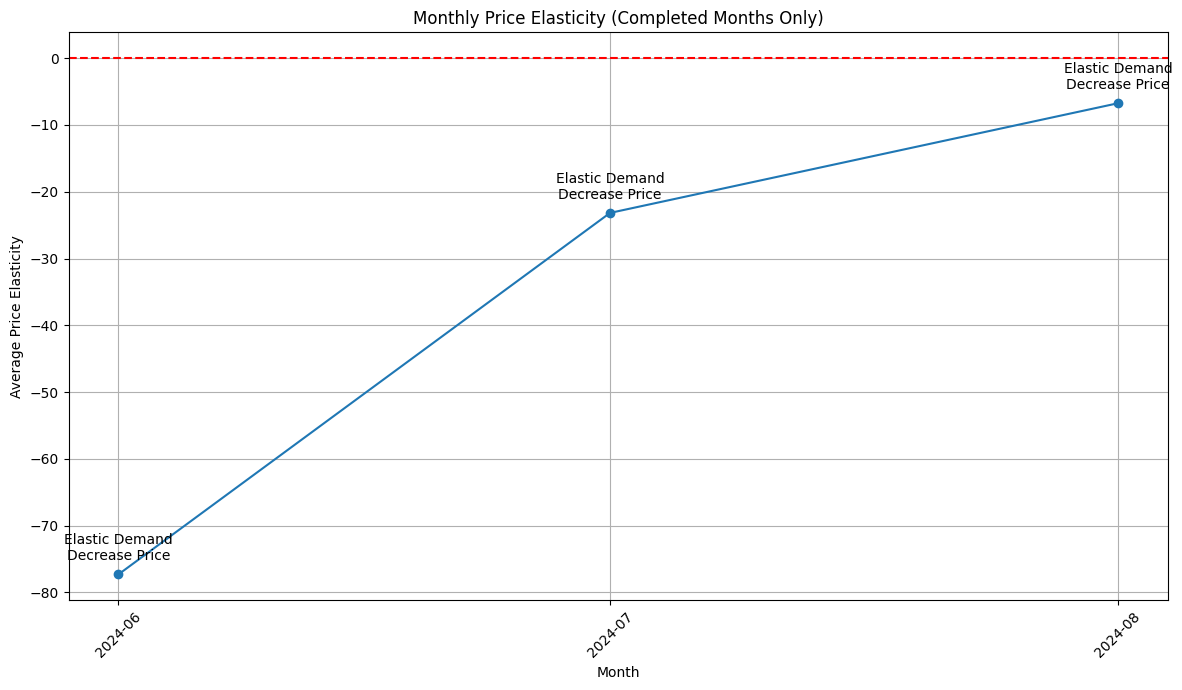

In [40]:
# Plot for complete months
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(monthly_elasticity['Month'], monthly_elasticity['price_elasticity'], marker='o', linestyle='-')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Annotating each point with demand type and recommendation
for i, row in monthly_elasticity.iterrows():
    ax.annotate(f"{row['demand_type']}\n{row['pricing_recommendation']}",
                (row['Month'], row['price_elasticity']),
                textcoords="offset points",  # how to position the text
                xytext=(0,10),  # distance from text to points (x,y)
                ha='center')  # horizontal alignment can be left, right or center

plt.title('Monthly Price Elasticity (Completed Months Only)')
plt.xlabel('Month')
plt.ylabel('Average Price Elasticity')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [41]:
all_months_elasticity = pd.concat([monthly_elasticity, current_month_elasticity])

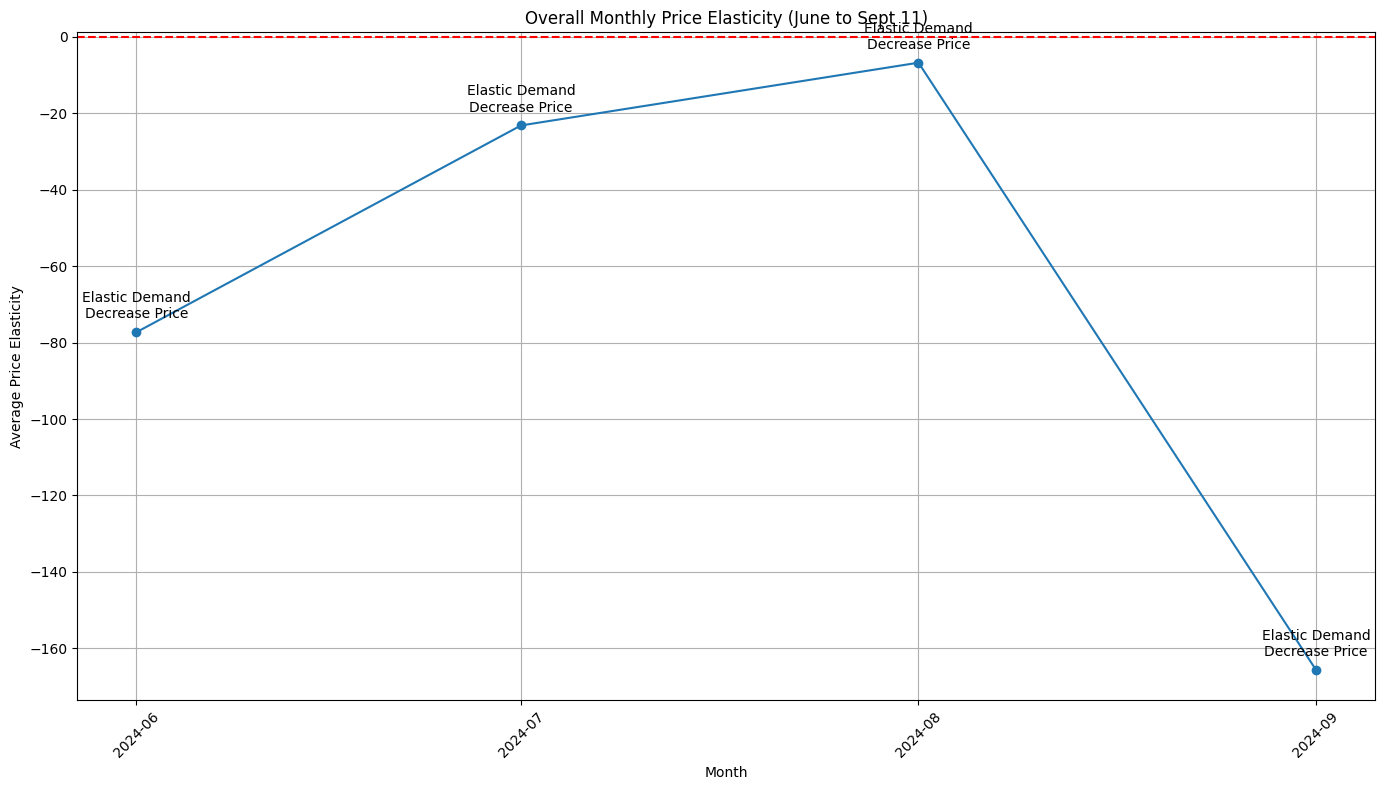

In [42]:
# Plot for all months
fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(all_months_elasticity['Month'], all_months_elasticity['price_elasticity'], marker='o', linestyle='-')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Annotating each point with demand type and recommendation
for i, row in all_months_elasticity.iterrows():
    ax.annotate(f"{row['demand_type']}\n{row['pricing_recommendation']}",
                (row['Month'], row['price_elasticity']),
                textcoords="offset points",  # how to position the text
                xytext=(0,10),  # distance from text to points (x,y)
                ha='center')  # horizontal alignment can be left, right or center

plt.title('Overall Monthly Price Elasticity (June to Sept 11)')
plt.xlabel('Month')
plt.ylabel('Average Price Elasticity')
plt.axhline(0, color='red', linestyle='--')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Analyzing Sales

In [19]:
def calculate_monthly_net_sales(data):
    # Group data by month and calculate total net sales
    monthly_sales = data.groupby(data['BILLING_DATE'].dt.to_period("M")).agg({'TOTAL_NET_SALES': 'sum'}).reset_index()
    monthly_sales['Month'] = monthly_sales['BILLING_DATE'].dt.to_timestamp()  # Convert Period to Timestamp
    return monthly_sales[['Month', 'TOTAL_NET_SALES']]

# Calculate monthly net sales for complete months and September
monthly_net_sales = calculate_monthly_net_sales(past_3months_df)
current_month_net_sales = calculate_monthly_net_sales(current_month_df)


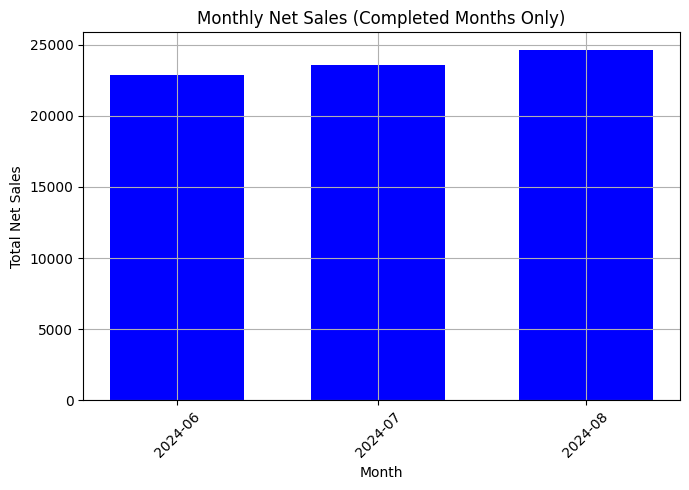

In [20]:
# Plot for complete months net sales
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(monthly_net_sales['Month'], monthly_net_sales['TOTAL_NET_SALES'], width=20, color='blue', align='center')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Monthly Net Sales (Completed Months Only)')
plt.xlabel('Month')
plt.ylabel('Total Net Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [91]:
# Check if September data is not empty and then create a plot
#if not september_net_sales.empty:
    #fig, ax = plt.subplots(figsize=(10, 8))
    #ax.bar(september_net_sales['Month'], september_net_sales['TOTAL_NET_SALES'], width=20, color='blue', align='center')
    #ax.xaxis.set_major_locator(mdates.MonthLocator())
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    #plt.title('Net Sales for September 2024')
    #plt.xlabel('Month')
    #plt.ylabel('Total Net Sales')
    #plt.grid(True)
    #plt.xticks(rotation=45)
    #plt.tight_layout()
    #plt.show()

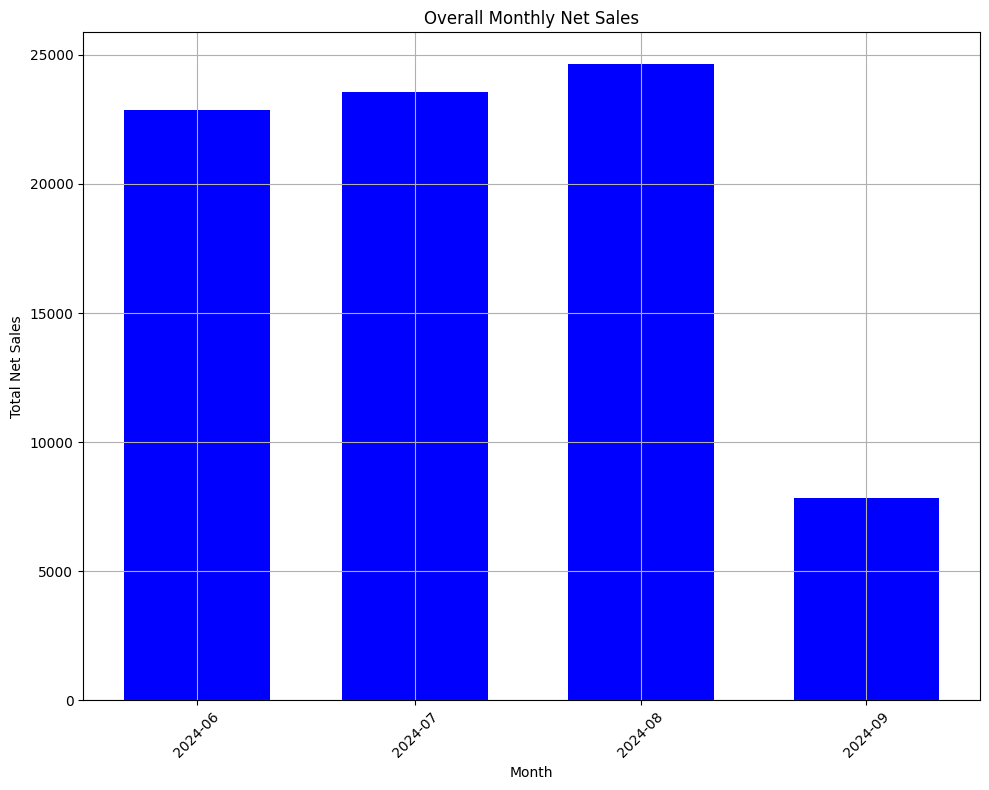

In [21]:
# Combine the complete months and September data
all_months_net_sales = pd.concat([monthly_net_sales, current_month_net_sales])

# Create a plot for all months net sales
fig, ax = plt.subplots(figsize=(10, 8))
ax.bar(all_months_net_sales['Month'], all_months_net_sales['TOTAL_NET_SALES'], width=20, color='blue', align='center')
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.title('Overall Monthly Net Sales')
plt.xlabel('Month')
plt.ylabel('Total Net Sales')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Optimal Price Range that lead to Highest Sales

In [43]:
# Group data by average price and calculate average net sales
price_sales = df.groupby('AVERAGE_PRICE').agg({'TOTAL_NET_SALES': 'mean'}).reset_index()

# Sort the results to see the top performing prices
price_sales_sorted = price_sales.sort_values(by='TOTAL_NET_SALES', ascending=False)

Aggregation of Data:

- By grouping the prices into bins and calculating the average net sales for these bins, we can reduce the noise that might be present if we looked at individual price points. This aggregation makes trends more visible

- Helps pinpoint the price range that historically leads to the highest sales.

<ipython-input-44-1666714b08d4>:7: FutureWarning: The provided callable <function mean at 0x78a119537d00> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  heatmap_data = price_sales_grouped.pivot_table(index='price_bin', values='TOTAL_NET_SALES', aggfunc=np.mean)


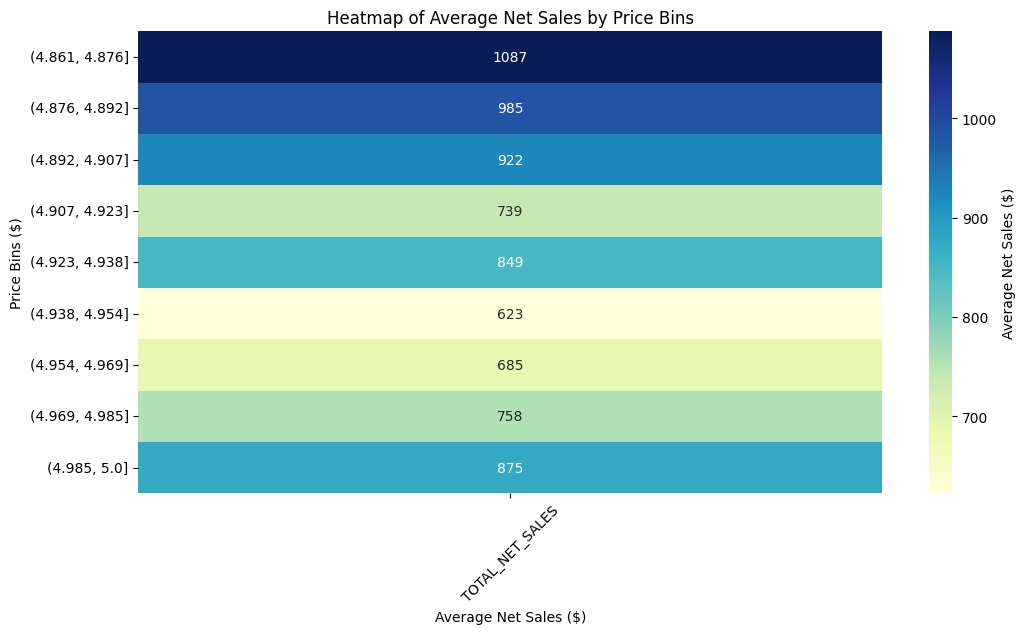

In [44]:
# Binning the prices
price_sales['price_bin'] = pd.cut(price_sales['AVERAGE_PRICE'], bins=np.linspace(price_sales['AVERAGE_PRICE'].min(), price_sales['AVERAGE_PRICE'].max(), 20))
price_sales_grouped = price_sales.groupby('price_bin', observed=True).agg({'TOTAL_NET_SALES':'mean'}).reset_index()

# Prepare data for heatmap
# Pivot the data for heatmap: 'price_bin' as rows, aggregated 'TOTAL_NET_SALES' needs to be the matrix
heatmap_data = price_sales_grouped.pivot_table(index='price_bin', values='TOTAL_NET_SALES', aggfunc=np.mean)

# Creating a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Average Net Sales ($)'})
plt.title('Heatmap of Average Net Sales by Price Bins')
plt.xlabel('Average Net Sales ($)')
plt.ylabel('Price Bins ($)')
plt.xticks(rotation=45)
plt.show()



Look for the darker or warmer colored cells in the heatmap, as these represent higher average net sales. In our case, the price range between 4.861 and 4.876 showing significant sales suggests this may be an optimal pricing segment.

In [45]:
# Ensuring the highest sales are accurately captured
price_sales['price_bin'] = pd.cut(price_sales['AVERAGE_PRICE'], bins=np.linspace(price_sales['AVERAGE_PRICE'].min(), price_sales['AVERAGE_PRICE'].max(), 20))
price_sales_grouped = price_sales.groupby('price_bin', observed=False).agg({'TOTAL_NET_SALES':'mean'}).reset_index()

# Sort by net sales descending
price_sales_grouped_sorted = price_sales_grouped.sort_values(by='TOTAL_NET_SALES', ascending=False)
optimal_price = price_sales_grouped_sorted.iloc[0]

print(f"The optimal price bin is {optimal_price['price_bin']} which leads to an average net sales of ${optimal_price['TOTAL_NET_SALES']:.2f}.")


The optimal price bin is (4.861, 4.876] which leads to an average net sales of $1087.17.


## Walmart Analysis - Price Suggestion

In [46]:
# Walmart Prices for the last 4 weeks
walmart_prices_last_4_weeks = [5.93, 5.63, 5.93, 5.93]

# Calculating average Walmart price over the 4 weeks
average_walmart_price = sum(walmart_prices_last_4_weeks) / len(walmart_prices_last_4_weeks)


# Calculating the price 10% cheaper than the 4-week average Walmart price
target_walmart_price = average_walmart_price * 0.90
print(f"Average Walmart Price over 4 weeks: ${average_walmart_price:.2f}")
print(f"Suggested Price (10% cheaper than Walmart's average): ${target_walmart_price:.2f}")

Average Walmart Price over 4 weeks: $5.85
Suggested Price (10% cheaper than Walmart's average): $5.27


In [47]:
current_price = 5.00 # our current price

# Optimal price range from heatmap
optimal_price_lower = 4.861
optimal_price_upper = 4.876

print(f"Current Price: ${current_price:.2f}")
print(f"Optimal Price Range: ${optimal_price_lower:.3f} to ${optimal_price_upper:.3f}")
print(f"Suggested Price (based on Walmart's average): ${target_walmart_price:.2f}")

# Determining final suggestion
# using min max to hold the value between the heat map range
# min compares between "final suggested price 10% cheaper" and f"inal price suggestion"
# max compares "final price suggestion" with "optimal price upper" -> it's rounding 4.87
final_price_suggestion = max(min(target_walmart_price, optimal_price_upper), optimal_price_lower) # adjusted to fit within your optimal price range identified by the heatmap
print(f"Final Price Suggestion: ${final_price_suggestion:.2f}")

Current Price: $5.00
Optimal Price Range: $4.861 to $4.876
Suggested Price (based on Walmart's average): $5.27
Final Price Suggestion: $4.88


MY INTENTION IS TO:

maximize sales volumes based on historical sales data that indicates this range is most favorable.

### Walmart - GROSS Margin Analysis

In [63]:
#for index, row in df.iterrows():
    #gross_margin = 0.30  # Target gross margin
    #cost_of_goods_sold = row['TOTAL_COGS']
    #required_price_for_margin = cost_of_goods_sold / (1 - gross_margin)
    #final_price_suggestion = 4.88  # final price suggestion

    # Formatting the date
    #date_str = row['BILLING_DATE'].strftime('%Y-%m-%d')

    # Ensuring the final price meets the margin requirement
    #if final_price_suggestion < required_price_for_margin:
        #print(f"Warning: On {date_str}, the final suggested price (${final_price_suggestion:.2f}) does not meet the gross margin requirement.")
    #else:
        #print(f"On {date_str}, the final suggested price (${final_price_suggestion:.2f}) meets the gross margin requirement.")


## Costco Analysis - Price Suggestion

In [59]:
# Example Costco prices for the last 4 weeks (replace with actual data)
costco_prices_last_4_weeks = [5.00, 5.02, 4.98, 5.01]  # Replace with actual data

# Calculate average Costco price over the last 4 weeks
average_costco_price = sum(costco_prices_last_4_weeks) / len(costco_prices_last_4_weeks)
print(f"Average Costco Price over the last 4 weeks: ${average_costco_price:.2f}")

Average Costco Price over the last 4 weeks: $5.00


In [60]:
# Calculate the lower and upper bounds of the price range (98% to 103% of Costco's price)
lower_costco_bound = average_costco_price * 0.98
upper_costco_bound = average_costco_price * 1.03

print(f"Price should be between ${lower_costco_bound:.2f} and ${upper_costco_bound:.2f} to stay competitive with Costco.")

Price should be between $4.90 and $5.15 to stay competitive with Costco.


In [61]:
# Your current price
current_price = 4.98  # Example current price

# Optimal price range from heatmap
optimal_price_lower = 4.861
optimal_price_upper = 4.876

# Compare the Costco price range with your current and optimal price range
print(f"Current Price: ${current_price:.2f}")
print(f"Optimal Price Range: ${optimal_price_lower:.3f} to ${optimal_price_upper:.3f}")
print(f"Suggested Price Range (based on Costco's average): ${lower_costco_bound:.2f} to ${upper_costco_bound:.2f}")


Current Price: $4.98
Optimal Price Range: $4.861 to $4.876
Suggested Price Range (based on Costco's average): $4.90 to $5.15


In [62]:
# Final suggested price: Ensure it falls within both the optimal range and the Costco range
final_price_suggestion = max(min(upper_costco_bound, optimal_price_upper), lower_costco_bound, optimal_price_lower)

print(f"Final Price Suggestion: ${final_price_suggestion:.2f}")


Final Price Suggestion: $4.90


## Costco - Gross Margin Analysis

In [ ]:
# I WILL NEED TO GET THE TOTAL COST OF GOOD SOLDS INCORPORATED INTO THE SQL QUERY TO EXTRACT FROM SNOWFLAKE
for index, row in df.iterrows():
    gross_margin = 0.30  # Target gross margin
    cost_of_goods_sold = row['TOTAL_COGS']  # Use the actual TOTAL_COGS for SKU

    # Calculate the minimum price to maintain gross margin
    required_price_for_margin = cost_of_goods_sold / (1 - gross_margin)

    final_price_suggestion = 'xxx'  # Replace this with your calculated final price suggestion

    # Ensuring the final price meets the margin requirement
    if final_price_suggestion < required_price_for_margin:
        print(f"Warning: Final suggested price (${final_price_suggestion:.2f}) does not meet the gross margin requirement.")
    else:
        print(f"Final suggested price (${final_price_suggestion:.2f}) meets the gross margin requirement.")

# Other ideas

- Time-Series Analysis: Look at elasticity over time to identify any trends or seasonal patterns.

- Consider running A/B testing with different price points within the range to find the optimal balance.

- Causal Analysis: Consider factors that might cause high elasticity days, like marketing campaigns or changes in competitor prices.

- Statistical Analysis: You might want to conduct further statistical analysis to determine if certain factors (like specific days of the week, monthly cycles, promotions, or other external factors) are associated with high elasticity days. This could help in planning pricing strategies more effectively.

- Confounding Factors: Consider if other factors might influence sales, such as promotions, seasonal effects, or market changes, which could also correlate with changes in pricing.

- Regression Analysis: For a more statistical approach, consider regression analysis to quantify how much price changes are expected to affect sales, adjusting for other variables.

- Correlation Analysis: Consider calculating the correlation coefficient between price and net sales to quantify their linear relationship.


- Regression Model: Develop a regression model to predict sales based on price, potentially including other variables like promotional activities, seasonality, or competitor pricing.